# Spam Detection - Data Analysis

- Add the project's root directory (two levels up) to the Python path so the modules can be imported, even if they arent in the current working directory:

In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join('..', '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

- Import the required libraries and modules, as well as our utility functions:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import seaborn as sns

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


from src.utils import load_config, get_project_root, print_text
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

In [ ]:
print(nltk.data.path)

## 1. Data Loading and Exploration
- Load raw training and test data from location in configuration file.

In [4]:
config = load_config()

train_path = os.path.join(get_project_root(), config['data']['task1']['raw']['train'])
test_path = os.path.join(get_project_root(), config['data']['task1']['raw']['test'])

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

- Display basic information about our test and training data:

In [5]:
print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)

Training Data Shape: (3619, 2)
Test Data Shape: (1552, 1)


- Choose a spam and not spam message from the data, use the given function to see if it is spam or not, then print it. We can use this to get a rough idea of what a spam message might look like:

In [ ]:
non_spam_sample = train_df[train_df['label'] == 0].iloc[0]
print("NON-SPAM SAMPLE:")
print_text(non_spam_sample['text'], non_spam_sample[-1])

print("\n")

spam_sample = train_df[train_df['label'] == 1].iloc[0]
print("SPAM SAMPLE:")
print_text(spam_sample['text'], spam_sample['label'])

## 2. Analysing Data
- Pie chart of spam vs. non-spam distribution

In [7]:
def map_labels(series, mapping):
    return series.map(mapping).to_numpy()

In [8]:
mapping = {0: "NotSpam", 1: "Spam"}
plot_labels = ["NotSpam", "Spam"]

train_labels = map_labels(train_df.iloc[:, -1], mapping)
train_counts = [(train_labels == "NotSpam").sum(), (train_labels == "Spam").sum()]

print(train_counts)

[np.int64(2551), np.int64(1068)]


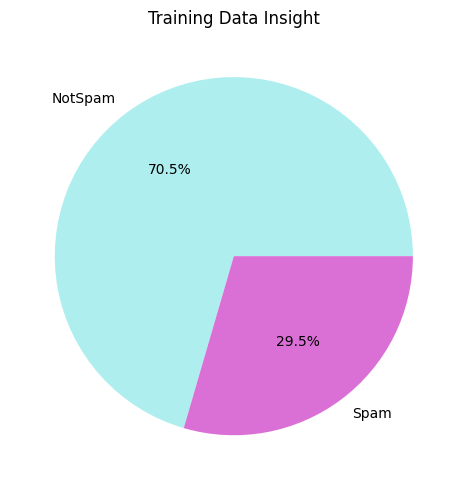

In [9]:
figure, axes = plt.subplots(figsize=(10, 5))

axes.pie(
    train_counts,
    labels=plot_labels,
    autopct='%1.1f%%',
    colors=['paleturquoise', 'orchid']
)

axes.set_title('Training Data Insight')
plt.tight_layout()
plt.show()

- Print key information

In [10]:
print(f"Training Set - NotSpam: {train_counts[0]}, Spam: {train_counts[1]}")

Training Set - NotSpam: 2551, Spam: 1068


## 3. Text Length Analysis
- Calculate average text length of a spam message vs a non-spam message.
- Plot distribution on histogram of average text lengths for spam vs. non-spam

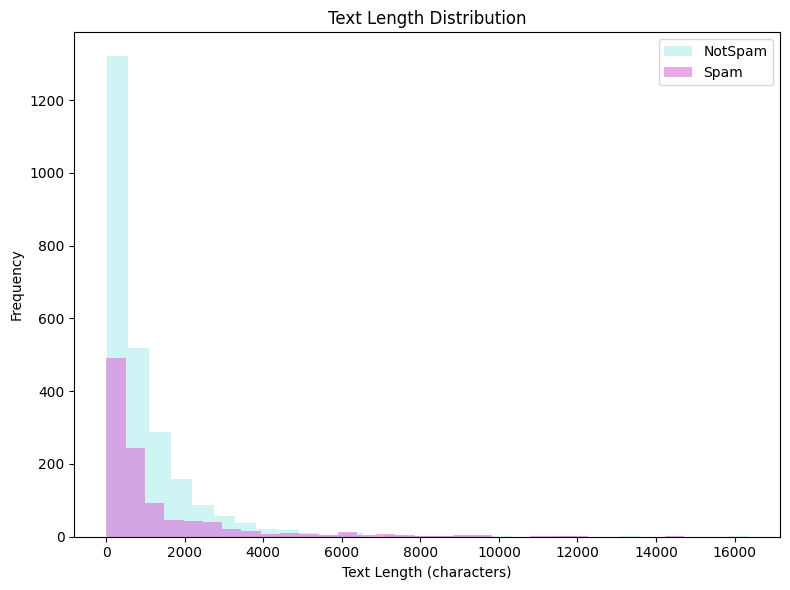

In [11]:
text_lengths = train_df.iloc[:, 0].apply(len)
spam_lengths = text_lengths[train_labels == "Spam"]
nonspam_lengths = text_lengths[train_labels == "NotSpam"]

spam_avg_len = spam_lengths.mean()
nonspam_avg_len = nonspam_lengths.mean()

plt.figure(figsize=(8, 6))
plt.hist(nonspam_lengths, bins=30, alpha=0.6, label='NotSpam', color='paleturquoise')
plt.hist(spam_lengths, bins=30, alpha=0.6, label='Spam', color='orchid')
plt.title('Text Length Distribution')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

- Key insights into the data, containing average text length for both spam and not spam, what the length of the largest spam message is, and how many spam messages have a length of over 500 characters. These all give us key insights into the composition of a spam message:

In [12]:
print(f"Average Text Length for Spam: {spam_avg_len:.2f} characters")
print(f"Average Text Length for Not Spam: {nonspam_avg_len:.2f} characters")
print(f"Max Spam Length: {spam_lengths.max()}")
print(f"Number of Spam Messages over 500 characters: {(spam_lengths > 500).sum()}")

Average Text Length for Spam: 1229.92 characters
Average Text Length for Not Spam: 964.39 characters
Max Spam Length: 14716
Number of Spam Messages over 500 characters: 580


## 4. Linguistic Features Analysis

In [13]:
texts = train_df.iloc[:, 0]

In [14]:
def length_avg_sentence(text):
    sentences = sent_tokenize(text)
    if not sentences:
        return 0
    return np.mean([len(word_tokenize(sent)) for sent in sentences])

In [15]:
avg_sent_lens = texts.apply(length_avg_sentence)

labels = pd.Series(map_labels(train_df.iloc[:, -1], mapping))

spam_avg_sent_len = avg_sent_lens[labels == "Spam"].mean()
nonspam_avg_sent_len = avg_sent_lens[labels == "NotSpam"].mean()

print(f"Average Spam Sentence Length: {spam_avg_sent_len:.2f} words")
print(f"Average Not Spam Sentence Length: {nonspam_avg_sent_len:.2f} words")

Average Spam Sentence Length: 19.42 words
Average Not Spam Sentence Length: 22.14 words


- Word count distributions:

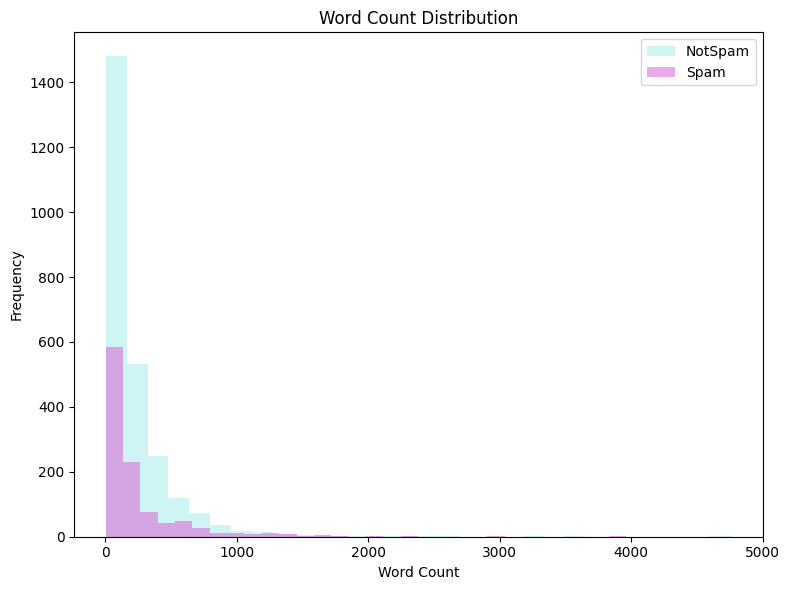

In [16]:
word_counts = texts.apply(lambda x: len(word_tokenize(x)))
spam_word_counts = word_counts[labels == "Spam"]
nonspam_word_counts = word_counts[labels == "NotSpam"]

plt.figure(figsize=(8, 6))
plt.hist(nonspam_word_counts, bins=30, alpha=0.6, label='NotSpam', color='paleturquoise')
plt.hist(spam_word_counts, bins=30, alpha=0.6, label='Spam', color='orchid')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

- Usage of special characters - how often are they being used in spam and not spam messages:

In [17]:
special_chars = ['!', '?', '$', '%', '&', '@', '*']

def count_special_chars(text):
    return sum(text.count(c) for c in special_chars)

special_char_counts = texts.apply(lambda x: count_special_chars(x))

spam_special_char_avg = special_char_counts[labels == "Spam"].mean()
nonspam_special_char_avg = special_char_counts[labels == "NotSpam"].mean()

print(f"Average Special Characters per Spam Message: {spam_special_char_avg:.2f}")
print(f"Average Special Characters per Not Spam Message: {nonspam_special_char_avg:.2f}")

Average Special Characters per Spam Message: 7.39
Average Special Characters per Not Spam Message: 5.09


- Exclamation mark frequency

In [18]:
def count_punctuation(text):
    punctuation = '.,!?;:'
    return sum(1 for char in text if char in punctuation)

punctuation_counts = texts.apply(count_punctuation)

spam_punctuation_avg = punctuation_counts[labels == "Spam"].mean()
nonspam_punctuation_avg = punctuation_counts[labels == "NotSpam"].mean()

print(f"Average Punctuation Mark Usage per Spam Message: {spam_punctuation_avg:.2f}")
print(f"Average Punctuation Mark Usage per Not Spam Message: {nonspam_punctuation_avg:.2f}")


Average Punctuation Mark Usage per Spam Message: 29.24
Average Punctuation Mark Usage per Not Spam Message: 25.42


- Exclamation mark density

In [19]:
def exclamation_density(text):
    exclam = '!'
    word_count = len(word_tokenize(text))
    excl_count = text.count(exclam)
    return excl_count / word_count if word_count > 0 else 0

In [20]:
exclamation_density_counts = texts.apply(exclamation_density)

spam_excl_density_avg = exclamation_density_counts[labels == "Spam"].mean()
nonspam_excl_density_avg = exclamation_density_counts[labels == "NotSpam"].mean()

print(f"Average Exclamation Mark Density for Spam: {spam_excl_density_avg:.4f}")
print(f"Average Exclamation Mark Density for Not Spam: {nonspam_excl_density_avg:.4f}")

Average Exclamation Mark Density for Spam: 0.0135
Average Exclamation Mark Density for Not Spam: 0.0019


## 5. Word Frequency Analysis

- Function to find most frequent words in the passed text collection, making sure to ignore any stopwords. This gives us a good idea as to what spam and not spam messages might be composed of.

In [21]:
def find_frequent_words(text_collection):
    cv = CountVectorizer(stop_words='english', max_features=20)
    word_counts = cv.fit_transform(text_collection)
    
    df = pd.DataFrame(
        word_counts.toarray(),
        columns=cv.get_feature_names_out()
    )

    word_totals = df.sum().sort_values(ascending=False)
    return word_totals

- Make a word cloud given a collection of text and a title to label the word cloud:

In [22]:
def make_word_cloud(text_collection, title):
    max_words = 15
    text = " ".join(text_collection)
    
    cloud = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=None,
        max_words=max_words
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

- Get all the spam and not spam texts, find the most frequent words, and print these. Also use them to make a word cloud:

Most Common Words in Spam:
subject        1179
com             755
http            618
company         522
www             460
00              418
font            389
information     387
email           377
price           363
nbsp            356
statements      341
new             303
99              263
pills           263
size            247
time            246
2004            237
free            233
td              222
dtype: int64


Most Common Words in Non-Spam:
ect        9627
hou        5039
subject    4403
enron      4356
2000       2973
gas        1929
deal       1921
meter      1639
cc         1619
hpl        1602
pm         1592
2001       1424
00         1383
com        1378
daren      1318
000        1312
10         1270
thanks     1252
01         1196
corp       1177
dtype: int64


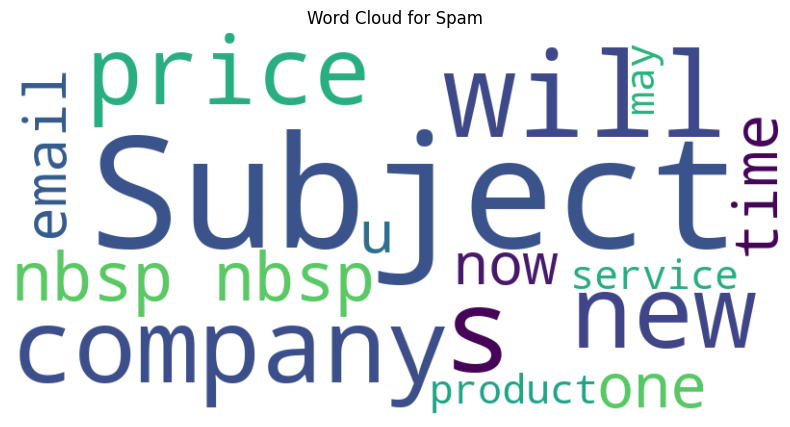

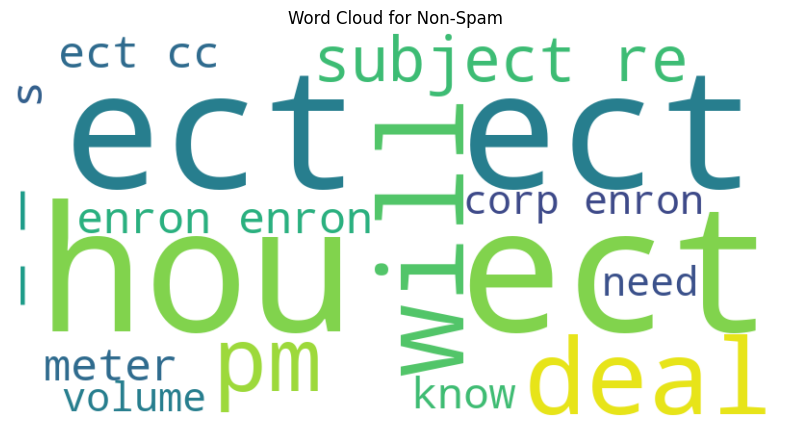

In [23]:
spam_texts = texts[labels == "Spam"]
nonspam_texts = texts[labels == "NotSpam"]

spam_word_counts = find_frequent_words(spam_texts)
nonspam_word_counts = find_frequent_words(nonspam_texts)

print("Most Common Words in Spam:")
print(spam_word_counts)
print("\n")
print("Most Common Words in Non-Spam:")
print(nonspam_word_counts)

make_word_cloud(spam_texts, 'Word Cloud for Spam')
make_word_cloud(nonspam_texts, 'Word Cloud for Non-Spam')

## 6. Correlation Analysis

- Use a dataframe to analyse whether there is any correlation between certain features - which may help when it comes to feature extraction:

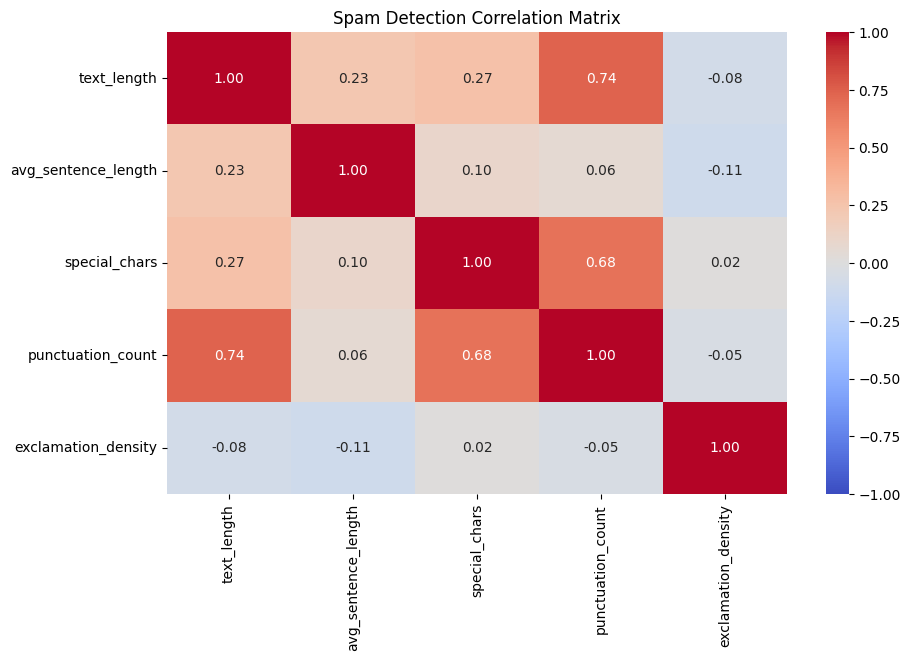

In [24]:
features_df = pd.DataFrame({
    'text_length': text_lengths,
    'avg_sentence_length': avg_sent_lens,
    'special_chars': special_char_counts,
    'punctuation_count': punctuation_counts,
    'exclamation_density': exclamation_density_counts,
})

correlations = features_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", 
            vmin=-1, vmax=1)
plt.title("Spam Detection Correlation Matrix")
plt.show()